In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import itertools

### 참조할 함수들
* pd.date_range 함수를 쓰면 모든 날짜/시간을 일일히 입력할 필요없이 시작일과 종료일 또는 시작일과 기간을 입력하면 범위 내의 인덱스를 생성해 준다.
* shift 연산을 사용하면 인덱스는 그대로 두고 데이터만 이동할 수도 있다.
* resample 연산을 쓰면 시간 간격을 재조정하는 리샘플링(resampling)이 가능하다. 이 때 시간 구간이 작아지면 데이터 양이 증가한다고 해서 업-샘플링(up-sampling)이라 하고 시간 구간이 커지면 데이터 양이 감소한다고 해서 다운-샘플링(down-sampling)이라 부른다.
* ohlc 메서드는 구간의 시고저종(open, high, low, close)값을 구한다.

# 시계열 분석 과정

In [2]:
df = pd.read_csv('Bitcoin/BTC-USD.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-02-02,23720.824219,24167.210938,23468.595703,23471.871094,23471.871094,3.206694e+10
1,2023-02-03,23469.412109,23678.103516,23279.955078,23449.322266,23449.322266,2.708307e+10
2,2023-02-04,23446.320313,23556.949219,23291.794922,23331.847656,23331.847656,1.563930e+10
3,2023-02-05,23332.248047,23423.435547,22841.759766,22955.666016,22955.666016,1.956426e+10
4,2023-02-06,22954.021484,23119.279297,22692.025391,22760.109375,22760.109375,2.382501e+10
...,...,...,...,...,...,...,...
361,2024-01-29,42030.914063,43305.867188,41818.332031,43288.246094,43288.246094,2.066848e+10
362,2024-01-30,43300.226563,43838.945313,42711.371094,42952.609375,42952.609375,2.384281e+10
363,2024-01-31,42946.250000,43717.406250,42298.945313,42582.605469,42582.605469,2.467363e+10
364,2024-02-01,42569.761719,43243.167969,41879.191406,43075.773438,43075.773438,2.142395e+10


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       366 non-null    object 
 1   Open       365 non-null    float64
 2   High       365 non-null    float64
 3   Low        365 non-null    float64
 4   Close      365 non-null    float64
 5   Adj Close  365 non-null    float64
 6   Volume     365 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.1+ KB


In [4]:
df[['Date']] = df[['Date']].astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       366 non-null    datetime64[ns]
 1   Open       365 non-null    float64       
 2   High       365 non-null    float64       
 3   Low        365 non-null    float64       
 4   Close      365 non-null    float64       
 5   Adj Close  365 non-null    float64       
 6   Volume     365 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 20.1 KB


In [5]:
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-02-02,23720.824219,24167.210938,23468.595703,23471.871094,23471.871094,3.206694e+10
1,2023-02-03,23469.412109,23678.103516,23279.955078,23449.322266,23449.322266,2.708307e+10
2,2023-02-04,23446.320313,23556.949219,23291.794922,23331.847656,23331.847656,1.563930e+10
3,2023-02-05,23332.248047,23423.435547,22841.759766,22955.666016,22955.666016,1.956426e+10
4,2023-02-06,22954.021484,23119.279297,22692.025391,22760.109375,22760.109375,2.382501e+10


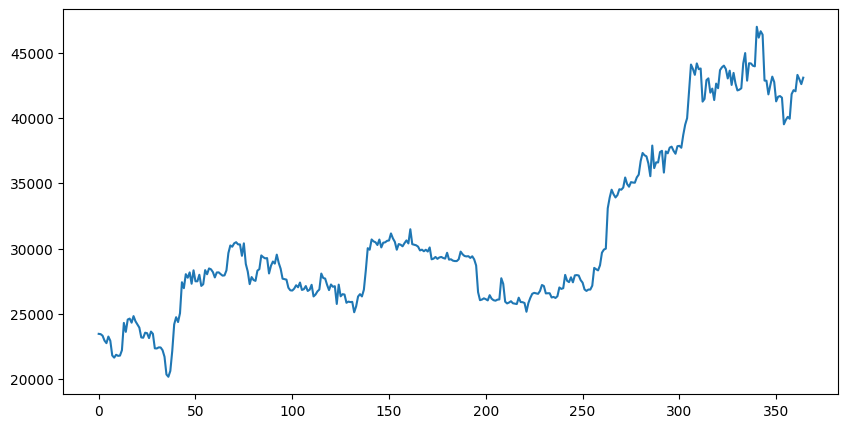

In [6]:
fig = plt.figure(figsize=(10,5))

plt.plot(df.index, df['Close'], label='Closing price')
plt.show()

## 시계열 분석: Seasonal Decompose
* 미래 예측을 목적으로 시간 정보가 포함된 데이터를 활용하는 분석 방법

* 시계열 정보는 일반적으로 추세 성분(trend component), 계절 성분(seasonal component), 불규칙 성분(irregular component)으로 구성되며, 관측값의 움직임을 이 성분으로 나누어서 설명합니다.
* 추세는 관측값의 전반적 상승 또는 하락 경향을 나타내는 성분입니다.
* 불규칙 성분은 특정한 규칙으로 설명할 수 없는 오차(error)를 나타내는 성분이에요.
* 시계열 데이터가 특정 주기에 따라 일정하게 변동할 때, 이 변동을 설명하는 요인이 계절 성분입니다.


### Trend 분석

In [7]:
#define moving average
df['SMA5'] = df['Close'].rolling(window=5).mean()
df['SMA10'] = df['Close'].rolling(window=10).mean()
df['SMA20'] = df['Close'].rolling(window=20).mean()
df = df.set_index('Date')
df = df.dropna()


In [8]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA5,SMA10,SMA20
Date,,,,,,,,,
2023-02-21,24833.048828,25126.851563,24200.363281,24436.353516,24436.353516,3.125210e+10,24560.004688,23654.844922,23203.102637
2023-02-22,24437.417969,24472.339844,23644.318359,24188.843750,24188.843750,3.020000e+10,24484.653125,23894.908985,23238.951270
2023-02-23,24190.718750,24572.089844,23693.919922,23947.492188,23947.492188,3.047626e+10,24345.896094,24108.848047,23263.859766
2023-02-24,23946.007813,24103.705078,23007.072266,23198.126953,23198.126953,2.681174e+10,24119.992969,24206.580274,23257.173731
2023-02-25,23200.125000,23210.210938,22861.558594,23175.375000,23175.375000,1.610072e+10,23789.238281,24093.333594,23268.159180


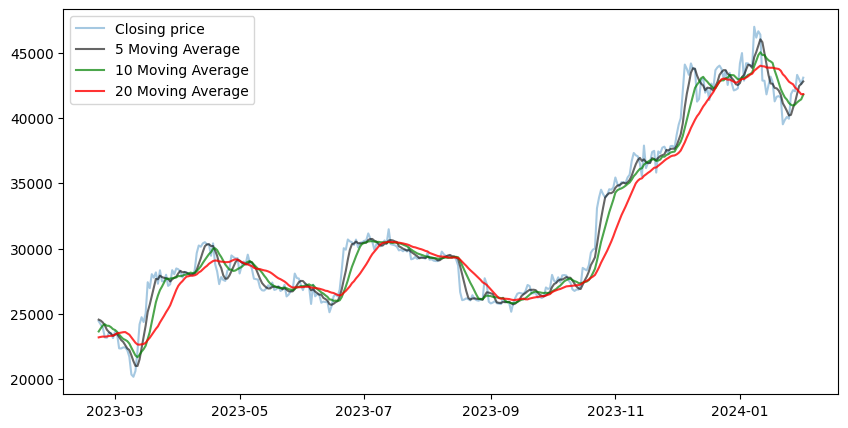

In [9]:
fig = plt.figure(figsize=(10,5))

plt.plot(df.index, df['Close'], label='Closing price', alpha=0.4)
plt.plot(df.index, df['SMA5'], label='5 Moving Average', color= "black", alpha=0.6)
plt.plot(df.index, df['SMA10'], label='10 Moving Average', color= "green", alpha=0.7)
plt.plot(df.index, df['SMA20'], label='20 Moving Average', color='red', alpha=0.8)
plt.legend()
plt.show()

k 값이 증가함에 따라 그래프가 완만해지는 것을 확인할 수 있습니다. 즉, 불규칙한 변동분이 사라지고, 추세가 보다 명확하게 드러납니다. k 값은 적정 수준의 추세 패턴을 찾을 때까지 반복적인 시행착오 과정을 통해서 결정합니다.

### 계절성을 포함한 성분 분해
* 성분 분해는 크게 두 가지 방법으로 이루어집니다.
* 덧셈(additive model; 가법 모델) 분해
* 곱셈(multiplicative moel; 승법 모델) 분해 

가법 모델은 시계열 데이터를 구성하는 각 성분이 덧셈을 통해 연결되어 있다고 가정하고, 승법 모델은 각 성분이 곱셈을 통해 연결되어 있다고 가정합니다. 
이 때, 승법 모델은 로그 변환을 통해 가법 모델로 쉽게 변환 할 수 있어요.
* Additive model : y(t) = Trend + Seasonality + Noise
* Multiplicative model : y(t) = Trend x Seasonality x Noise

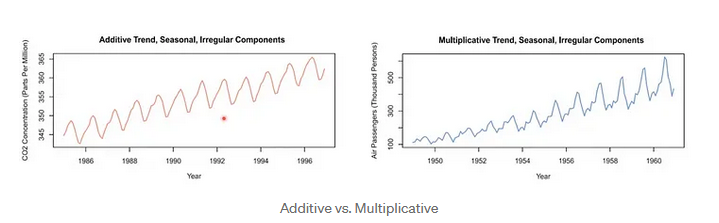

모델 선택은 시계열 데이터의 특성을 고려하면 되는데, 아래 그림의 왼편 그래프와 같이 시간에 따른 데이터 변동이 일정한 경우는 가법 모델을 활용한 데이터 분해가 적합합니다. 반대로, 변동폭이 관측값의 수준에 비례해서 변하는 경우 승법 모델을 적용하는 것이 좋습니다.

가법 모델을 기초로 기본 원리를 설명 해보겠습니다.

1. 앞서 이동 평균을 구할 때 사용한 k 값을 데이터의 주기에 맞게 설정합니다. 일반적으로분기 데이터인 경우 k=4, 월별 데이터의 경우 k=12, 주별 규칙을 가지고 있는 일 데이터에서는 k=7로 설정합니다. 이렇게 설정한 값을 기초로 추세 성분을 계산합니다. 위에서 함께 확인한 그래프와 같이 평활(smoothing)된 추세를 확인할 수 있어요.
2. 실제 관측값에서 추세를 제거한 시계열을 계산합니다. (y(t) — Trend)
3. 계절성분을 측정하기 위해, 계절별 추세를 제거한 값(y(t) — Trend)의 평균을 구합니다. 이렇게 하면 계절 성분 값이 0 근처의 값이 되도록 조정되는데, 이때 계절별 값을 순서대로 모으고 각 연도의 데이터에 대한 수열을 복제해서 계절 성분을 구해 Seasonality 값을 얻을 수 있습니다.
4. 마지막으로 관측값에서 계절성과 추세 성분을 빼서 나머지 불규칙 성분을 계산합니다. (Noise = y(t) — Trend — Seasonality)

* Python의 statsmodels 패키지의 seasonal_decompose() 함수를 활용하면 간단하게 시계열 성분을 분해할 수 있습니다. 제가 구상한 데이터는 주말을 제외한 월-금요일에만 관측값이 존재하기 때문에, 한 달 주기로 계절성 확인을 위해 freq=20으로 설정했습니다.

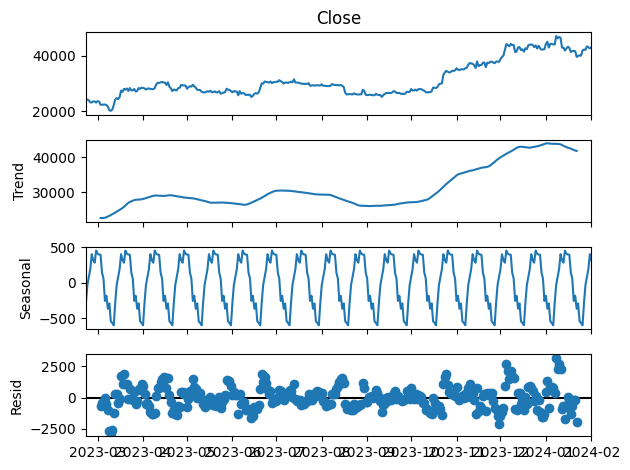

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_price = df.loc[:,'Close']
result = seasonal_decompose(df_price, model='addictive', period=20)
result.plot()
plt.show()

* 전반적으로 우상향 하는 Trend를 확인할 수 있고,
* Seasonal 성분은 20일을 주기로 반복됩니다.
* 그리고 Trend + Seasonal 값과 Observed 값의 차이가 Residual로 나타납니다.
* 고전적인 분해 방식을 사용했는데요. 실제 시계열 분석을 진행할 때 추천되는 방법은 아닙니다.

### 고전적인 분해 방식이 가지는 문제점에 대해서는 간단히 짚어보도록 하자.
* 앞서 추세 꺼내보기 부분에서도 설명했지만, sesonal_compose()는 이동 평균을 활용하기 때문에 설정한 주기가 k일 때 데이터 양 끝의 (k-1)/2개 관측값에 대한 추세 추정 값을 얻을 수 없습니다.
* 계절 성분이 매년 반복된다고 가정합니다. sesonal_compose() 결과를 보면 Seasonal 값이 20일 주기로 완전히 동일하게 반복되는 것을 확인할 수 있는데요. 현실에서는 시간적인 변화에 따라 계절성 또한 달라지게 되지요.
* 특정 기간의 시계열 값이 크게 튈 수 있습니다. 

## 정상성(Stationarity)과 자기상관(Autocorrelation)
* Stationarity는 시계열 데이터의 특성 중 하나로, 시간에 따라 평균이나 분산이 일정하며 주기적인 패턴이 없는 안정적인 특성을 의미합니다.
* Autocorrelation - 시계열 데이터에서 현재 시점의 관측값과 과거 시점의 관측값 간의 상관관계를 측정하는 지표로, 시계열 데이터 내에서 발생하는 자기 상관 구조를 파악하는 데 사용됩니다.

시계열 데이터가 정상성을 띤다는 것은 “데이터의 분포가 시간에 따라 변하지 않는다”는 의미이며, 세 가지 기준으로 이를 판단할 수 있습니다 :
* 트랜드가 없다 (오르거나 줄어들지 않는다)
* 분산이 일정하다
* 자기상관이 일정하다

### 자기상관(Autocorrelation) 기본 계념 설명
자기상관은 ACF(Autocorrelation Function)을 통해 시각화합니다.

ACF 그래프
* x 축은 (지연된) 시차를 나타내고,
* y 축은 상관계수를 보여줍니다.
* 시차가 0일 때 모든 시계열의 자기상관계수는 1이며, 정상성을 띠는 데이터는 2부터 n차 지연까지의 자기상관계수가 0에 가깝게 나타납니다.
* 그림에서 하늘색으로 표시된 영역은 신뢰구간을 의미하고요. 아래 경우는 일부 시차를 제외하고 자기상관계수가 대체로 0에 가깝게 위치하고 있어요.

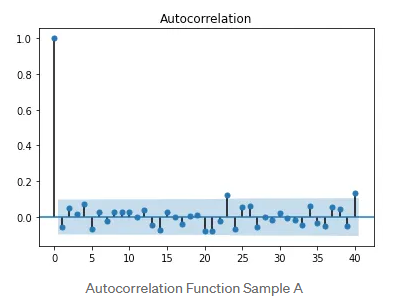

* 반면 다음 ACF 그래프는 거의 모든 시차에 대해 자기상관계수가 허용 범위를 초과하고 있습니다.
* 이 경우 관찰값은 비정상적(Non-stationary)이며, 시차가 커질 수록 자기상관계수가 점진적으로 줄어드는 형태를 보이는 것은 시간이 지날 수록 데이터 간의 자기 상관이 감소한다는 것을 보여줍니다.
* 즉, 어제의 데이터가 오늘을 가장 잘 설명하고, 일주일, 한달, 과거로 갈 수록 데이터의 상관성은 상대적으로 낮아진다는 의미입니다.

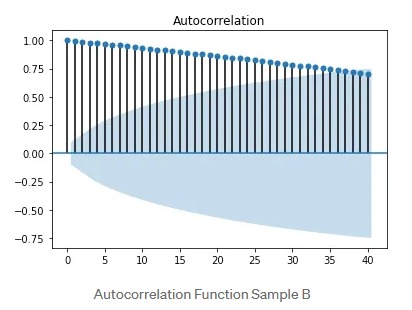

### White Noise와 Random Walk
* White Noise는 일정한 규칙 없이 전체적이고 일정한 범위를 가진 상태로, 대표적으로 정상성을 나타내는 시계열입니다.
* Random Walk는 White Noise에서 한 단계가 더해진 개념으로, 사전적 정의는 ‘임의 방향으로 향하는 연속적 걸음’

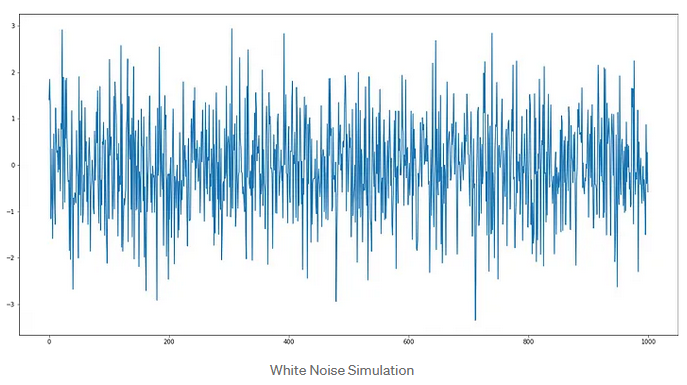

White Noise는 다음 세 가지 전제 조건을 가지고 있어요 :

* 평균이 일정하다.
* 분산이 일정하다.
* 관측값 간의 상관관계가 없다. (유의하지 않다)

* ‘정상화된 시계열은 예측이 불가하다’고 설명했는데, 이는 어떤 값을 예측했을 때 그 결과의 잔차(실제값과 예측값의 차이)가 White Noise의 형태를 띠고 있다면, 해당 예측 모델은 최적화된 상태라는 의미합니다. 더 이상 예측이 불가한 상태까지 패턴이 모두 추출되어 모델에 반영되었기 때문이에요.

* Random Walk 또한 예측이 불가하지만, White Noise와 다른 부분은 Random Walk이 직전의 관찰값에 기초한다는 점이에요. 이 개념은 주식 가격의 움직임을 설명하는 데에 자주 사용되는데, “오늘의 주가 = 어제의 주가 + Noise”로 간단히 나타낼 수 있습니다. 이 때, 어제의 주가에 더해지는 Noise가 바로 White Noise에 해당합니다.

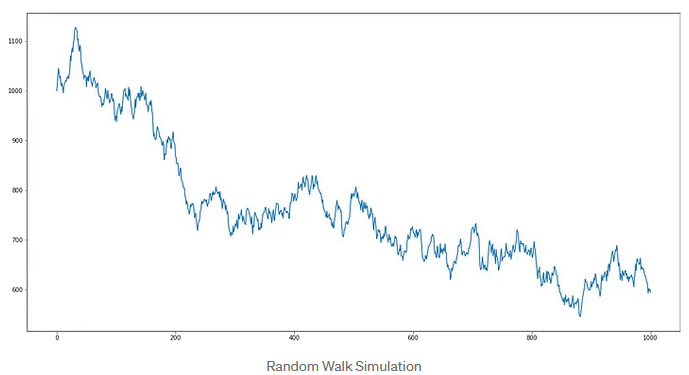

* Random Walk 모델은 비정상적이며, 통상 긴 주기로 보았을 때 상향 또는 하향하는 추세를 가지고, 갑작스럽고 예측할 수 없는 방향 변화를 보입니다.
* Random Walk는 쉽게 정상화할 수 있는데, 다음의 변형된 수식을 보면 간단히 알 수 있습니다 : “오늘의 주가 — 어제의 주가 = Noise” 즉, 오늘 주가(t)에서 어제 주가(t-1)을 빼주면 되는데, 이를 차분(Difference)이라고 합니다.

### Augmented Dickey-Fuller (ADF) 검정
* 왜 Augmented Dickey-Fuller (ADF)를 사용하는가? - 시각적으로 정상성을 판별하기 불분명한 경우, 측정 가능한 방식으로 정상성을 판별하기 위해
* ADF가 무었인가? - ADF 검정은 주어진 시계열 데이터가 정상 시계열인지 여부를 확인하기 위해 추세의 존재 여부를 테스트합니다.
* 정상 시계열은 시간에 따라 평균과 분산이 일정하며, ADF 검정에서는 단위근이 없다는 가설을 확인하여 시계열 데이터의 안정성을 평가합니다.
* 단위근은 시계열 데이터가 추세를 가지고 있어 계속해서 변하는 것을 나타냅니다.



단위근이있을때 시계열이 비정상적인지 이유

* 단위근이 존재할 때 시계열이 비정상적인 이유는 추세나 계절성과 같은 시간에 따라 계속해서 증가하거나 감소하는 경향을 보이기 때문입니다. 이러한 추세나 계절성이 지속되면 시계열 데이터의 평균이나 분산이 시간에 따라 계속해서 변하게 됩니다.
* 단위근이 존재하는 경우에는 시계열 데이터의 특성이 불안정하며 예측이나 통계적 추론이 어려울 수 있습니다.
* 시계열 분석에서 단위근의 존재 여부를 확인하는 것은 안정성을 평가하고 적절한 모델링을 수행하는 데 중요합니다.
* ADF 검정은 이러한 목적으로 사용되며, 단위근이 없다는 결론은 시계열 데이터가 안정적이라는 것을 시사합니다.

ADF 검정의 논리를 간단히 설명하면 :

* ADF는 기본적으로, 시계열에 단위근이 존재한다고 가정합니다. 즉, 시계열이 비정상적이라고 가정합니다.
* 검정 결과 귀무 가설이 기각된다면 ( = p-value가 유의수준 보다 작다면) 대상 시계열은 정상으로 판단 될 수 있습니다.
* 검정 결과 귀무 가설이 기각되지 않는다면 대상 시계열은 비정상으로 판단 됩니다.

## ARIMA 모델
* AR(auto-regressive) - AR 모형은 과거가 미래를 예측한다는 아주 직관적인 상식에 기반합니다.
* I(integrated) - I는 차분에 대한 정보를 나타냅니다.
* MA(moving average) - MA 모형은 평균을 중심으로 각 시계열 값이 가지는 오차를 모형에 반영합니다.


### AR(auto-regressive) 모형
* AR 모형을 추정할 때 가장 중요한 결정 사항은 얼마나 먼 과거의 데이터까지 모형에 고려할 것인지입니다.
* AR 모형에서 현재 시계열을 과거 p 시차의 시계열로 설명하는 확률 모형을 AR(p) 모형이라고 하는데요.
* 분석 대상이 되는 데이터에 어떤 p 값이 적절할지 결정하고자 한다면 PACF(partial autocorrelation function)를 그려보는 것이 좋습니다.

ACF / PACF
* ACF가 지연된 시차에 따라 현재 시간의 시계열 값과 이전 시간의 시계열 값의 상관관계를 시각적으로 나타낸다면
* PACF는 “각 차수”의 데이터가 가지는 상관관계를 나타냅니다. 즉, 부분자기상관은 두 시점 간의 상관관계에서 다른 시점의 영향을 제거하기 때문에, PACF가 0이 아닌 차수를 선별해서 AR 모형에 포함합니다.

* 아래 그래프는 AR(2) 모형에 맞춘 데이터 시뮬레이션의 PACF입니다. 시차가 2를 초과하는 부분부터 상관계수가 0으로 절단되는 것을 확인할 수 있습니다.
* 즉 p = 3이 적절한 값이 됩니다.

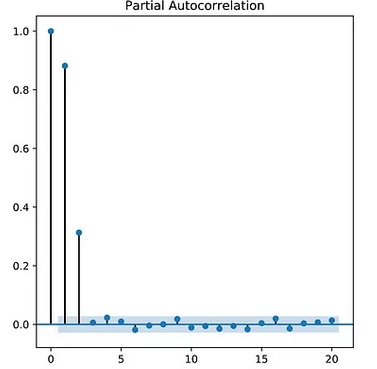


### MA(moving average) 모형
* MA 모형은 평균을 중심으로 각 시계열 값이 가지는 오차를 모형에 반영합니다.

MA(q) 모형의 일반적인 형태는 다음과 같아요 :

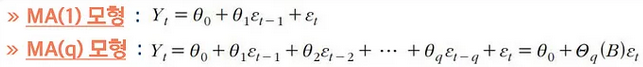

* MA 모형은 AR 모형과 다르게, ACF를 그렸을 때 차수 q를 넘는 부분을 0으로 절단하므로, 이를 통해서 적절한 차수를 판단할 수 있습니다.

### I(integrated)
* 비정상 시계열을 정상화 하기 위한 방법으로 차분(differencing)을 소개했습니다. ARIMA 모형의 I는 바로 그 차분에 대한 정보를 나타냅니다.
* 즉, d차 차분한 시계열이 AR(p) 모델과 MA(q) 모형을 따를 때, 이 시계열은 ARIMA(p, d, q) 모형으로부터 생성되었다고 말합니다.
* 한 단계 더 나아가 시계열이 계절 변동을 포함하고 있다면, 바로 앞서 설명한 ARIMA의 p, d, q 세 가지 요소에 더해 계절주기를 나타내는 S를 추가하여 ARIMA(p, d, q)(P, D, Q)_S로 나타냅니다.

기존의 데이터가 non-stationary일때 stationary로 바꾸기 위해 차분을 적용한다. 
1차분이라 함은 기존의 시점에서 시점의 shift(1)을한 차이를 나타낸다.
2차분이라 함은 기존의 시점에서 시점의 shift(2)를한 차이를 나타낸다.
d차분이라 함은 기존의 시점에서 시점의 shift(d)를한 차이를 나타낸다.
차분: 현시점 데이터에서 d시점 이전의 데이터를 뺀것 

### ARIMA(auto-regressive integrated moving agerage) 모형
ARIMA 모형을 식별하기 위해 어떤 데이터를 사용해야 할까요?
1. 먼저, 시계열 데이터를 그래프로 시각화하여 시계열이 정상성을 띄는지 확인합니다.
2. 만약 시계열에 특별한 변동이 있거나, 그 변동성이 시간에 따라 변해서 시계열이 안정적이지 않다면 차분, 변수 변환을 통해 시계열을 정상 시계열로 변환합니다. 이 과정에서 ARIMA(p, d, q)의 d에 해당하는 차수와 변수 변환 형태가 정해집니다.
3. 이후 안정화된 시계열을 사용하여 ARMA(p, q) 모델을 적용할 수 있으며, ACF와 PACF를 그려 적정 p, q를 특정합니다. 간결의 원칙에 따라 가능한 간단한 모형을 선택하고, 시계열을 모형화할 때는 3차 이하의 AR, MA 또는 ARMA 모형을 활용하는 것이 일반적입니다. 만약 ACF와 PACF를 통해 시차를 특정하기 어렵다면, 몇 가지 저차 시계열 모형을 작성한 뒤 AIC, BIC와 같은 모형 선택 기준을 활용하여 최적 모형을 선별할 수 있습니다.

* 이런 복잡한 과정을 획기적으로 간소화할 수 있는 도구가 있어요. 바로 R 프로그램의 auto.arima 함수입니다! 2008년에 만들어진 이 함수는 ARIMA 모형의 p, d, q를 자동으로 식별하여 추정합니다.

### 적합한 모델 찾기

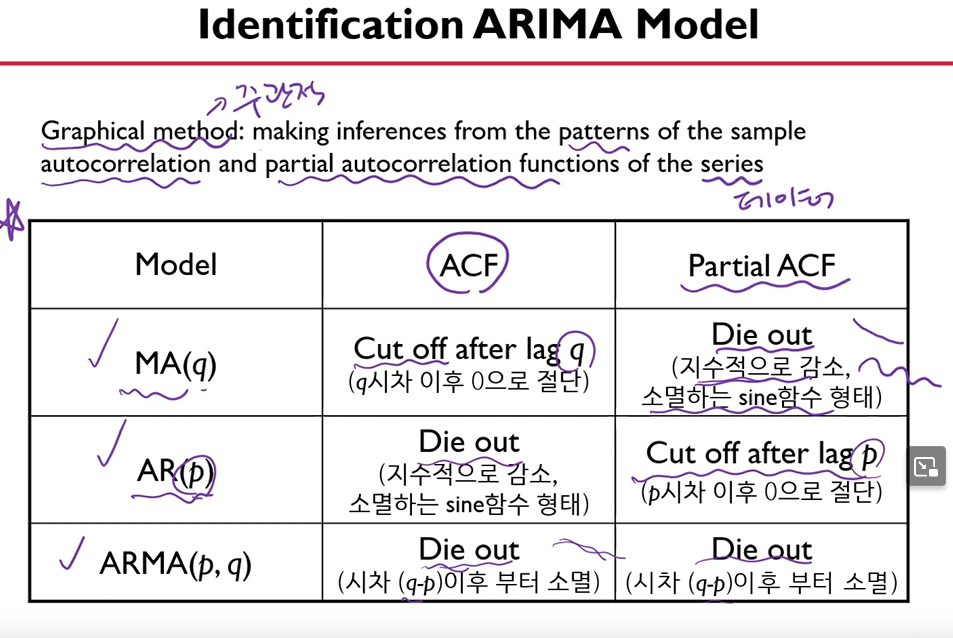

# 비트코인 시계열 분석 실습

### Preprocessing

In [11]:
df = pd.read_csv('Bitcoin/BTC-USD.csv')
df[['Date']] = df[['Date']].astype('datetime64[ns]')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-02-02,23720.824219,24167.210938,23468.595703,23471.871094,23471.871094,3.206694e+10
1,2023-02-03,23469.412109,23678.103516,23279.955078,23449.322266,23449.322266,2.708307e+10
2,2023-02-04,23446.320313,23556.949219,23291.794922,23331.847656,23331.847656,1.563930e+10
3,2023-02-05,23332.248047,23423.435547,22841.759766,22955.666016,22955.666016,1.956426e+10
4,2023-02-06,22954.021484,23119.279297,22692.025391,22760.109375,22760.109375,2.382501e+10


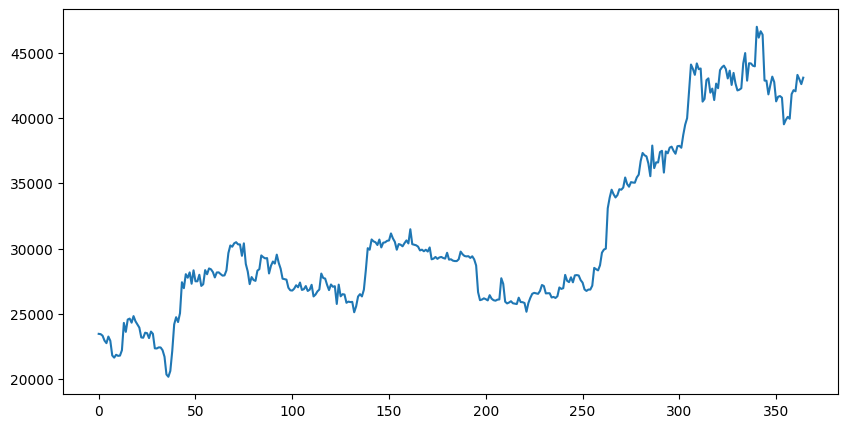

In [12]:
fig = plt.figure(figsize=(10,5))

plt.plot(df.index, df['Close'], label='Closing price')
plt.show()

In [13]:
#define moving average
df['SMA5'] = df['Close'].rolling(window=5).mean()
df['SMA10'] = df['Close'].rolling(window=10).mean()
df['SMA20'] = df['Close'].rolling(window=20).mean()
df = df.set_index('Date').asfreq('D')
df = df.dropna()

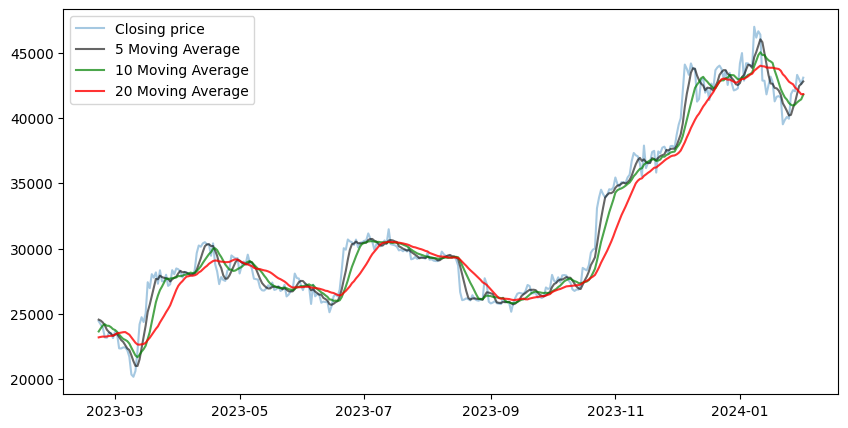

In [14]:
fig = plt.figure(figsize=(10,5))

plt.plot(df.index, df['Close'], label='Closing price', alpha=0.4)
plt.plot(df.index, df['SMA5'], label='5 Moving Average', color= "black", alpha=0.6)
plt.plot(df.index, df['SMA10'], label='10 Moving Average', color= "green", alpha=0.7)
plt.plot(df.index, df['SMA20'], label='20 Moving Average', color='red', alpha=0.8)
plt.legend()
plt.show()

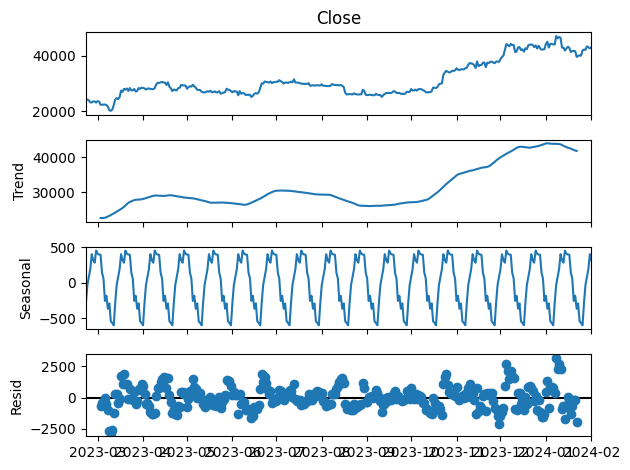

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_price = df.loc[:,'Close']
result = seasonal_decompose(df_price, model='addictive', period=20)
result.plot()
plt.show()


In [16]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

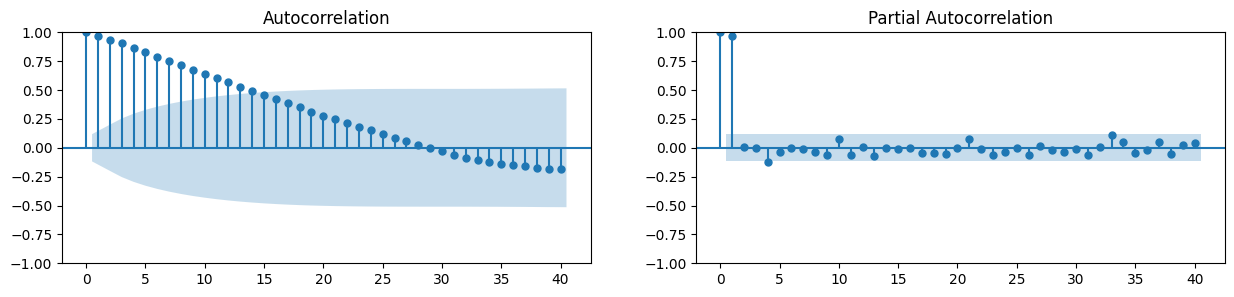

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,ax = plt.subplots(1,2, figsize=(15,3))
plot_acf(train_df['Close'], lags=40, alpha=0.05, ax=ax[0])
plot_pacf(train_df['Close'], lags=40, alpha=0.05, ax=ax[1])
plt.show()

* 데이터가 Non-stationary한 시계열 데이터임으로 stationary한 시계열 데이터로 변환 해야함.
* stationary 시계열 데이터로 변환하기 위해 차분을 적용해야할것으로 보임.

In [18]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(train_df['Close'])
print(results)
print()
print('Test Statistic: ', -0.7236972854819306)
print('p-value: ', 0.8405155571539968)
print('Lags Used: ', 0)
print('Number of Observations Used: ', 274)
print('Critical Values: ', '{1%: -3.4544435065994437, 5%: -2.8721468827772774, 10%: -2.572422013959188}')
print('Maximized Information Criterion: ',  4062.296900207386)

(-0.6882423886409401, 0.8497715636207877, 0, 275, {'1%': -3.454355055831705, '5%': -2.8721080938842976, '10%': -2.572401325619835}, 4077.477132329148)

Test Statistic:  -0.7236972854819306
p-value:  0.8405155571539968
Lags Used:  0
Number of Observations Used:  274
Critical Values:  {1%: -3.4544435065994437, 5%: -2.8721468827772774, 10%: -2.572422013959188}
Maximized Information Criterion:  4062.296900207386


ADF를 진행해본결과 p값이 0.05를 넘기때문에 귀무가설을 기각하지 못하게 됩니다. 즉 해당 데이터는 정상성을 만족하지 못한다 라고 할 수 있습니다. 따라서 이러한 정상성을 해결하고자 차분을 진행해 주어야한다.

### 비트코인 차분 변환
현실에서 우리가 분석하고자 하는 많은 데이터는 정상성을 띠고 있지 않을 거에요. 그래서 시계열 분석을 위해서는 몇 가지 간단한 조작을 통해 비정상 데이터를 정상으로 변환하는 과정이 필요합니다.


시계열 정상 변환을 위해 알아야 하는 기본 규칙은 다음과 같습니다 :
* 변동폭이 일정하지 않을 때는 로그 변환으로, 분산이 일정하게 유지되도록 만들기
* 추세 또는 계절적 요인은 차분을 통해 평균이 일정한 시계열로 변환하기

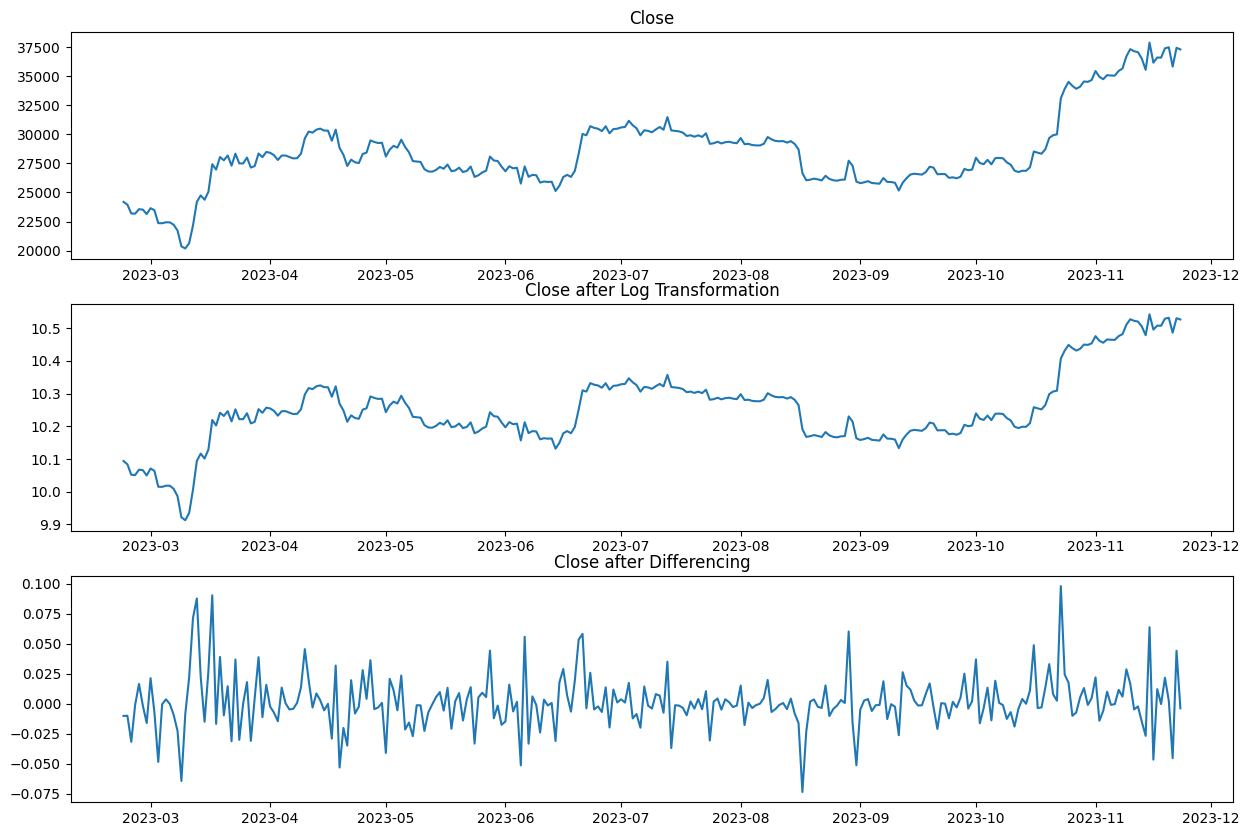

In [19]:
# 주가가 큰폭으로 움직이는것 확인, 로그변환 필요
train_df['Close-log'] = np.log(train_df['Close'])
# 트랜드가 우샹향하는것 확인, 차분과정 필요.
train_df['Close-station'] = train_df['Close-log'].diff(1)
train_df = train_df.dropna()

fig,ax = plt.subplots(3, figsize=(15,10))

#비트코인 주가
ax[0].plot(train_df['Close'])
ax[0].set_title('Close')

#비트코인 주가 로그변환 
ax[1].plot(train_df['Close-log'])
ax[1].set_title('Close after Log Transformation')

#바트코인 주가 차분변환
ax[2].plot(train_df['Close-station'])
ax[2].set_title('Close after Differencing')

plt.show()

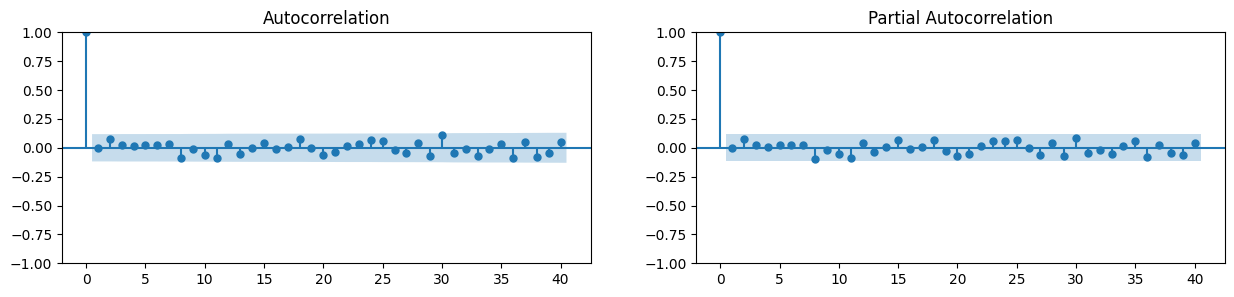

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,ax = plt.subplots(1,2, figsize=(15,3))
plot_acf(train_df['Close-station'], lags=40, alpha=0.05, ax=ax[0])
plot_pacf(train_df['Close-station'], lags=40, alpha=0.05, ax=ax[1])
plt.show()
    

In [21]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(train_df['Close-station'])
#print('results')
print('Test Statistic: ', -18.866761921622146)
print('p-value: ', 0.0)
print('Lags Used: ', 0)
print('Number of Observations Used: ', 344)
print('Critical Values: ', '{1%: -3.4495033946549123, 5%: -2.8699787979596136, 10%: -2.5712658305164955}')
print('Maximized Information Criterion: ', -1546.465331524812)


Test Statistic:  -18.866761921622146
p-value:  0.0
Lags Used:  0
Number of Observations Used:  344
Critical Values:  {1%: -3.4495033946549123, 5%: -2.8699787979596136, 10%: -2.5712658305164955}
Maximized Information Criterion:  -1546.465331524812


ACF 그래프:
* "ACF 그래프는 일부 시차를 제외하고 자기상관계수가 대체로 0에 가깝게 위치하고 있다"는 말은 시계열 데이터의 자기상관이 크게 나타나지 않고, 대체로 무작위로 분포하고 있다는 것을 의미합니다.
* 이는 데이터가 정상 시계열로 변환되었음을 시사합니다.

ADF 검정 결과:
* "ADF 검정 결과 p-value는 0에 근사한 값"으로 귀무 가설을 기각한다는 것은 단위근이 없다는 것입니다.
* 따라서 시계열 데이터가 정상 시계열로 변환되었다고 해석할 수 있습니다.

In [22]:
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(train_df['Close'], order=(1,1,1))
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  275
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2155.121
Date:                Mon, 05 Feb 2024   AIC                           4316.242
Time:                        20:05:13   BIC                           4327.082
Sample:                    02-22-2023   HQIC                          4320.593
                         - 11-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3170      0.855     -0.371      0.711      -1.993       1.359
ma.L1          0.2656      0.866      0.307      0.759      -1.431       1.962
sigma2      4.007e+05   2.02e+04     19.804      0.000    3.61e+05     4.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               180.29
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.76
Prob(H) (two-sided):                  0.85   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

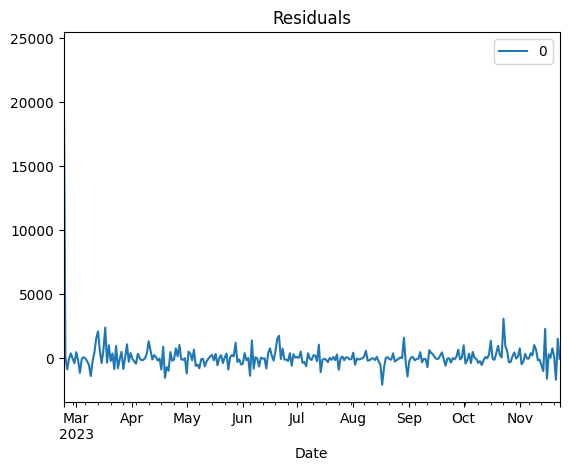

In [23]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residuals')
plt.show()

Overall, the model has relatively high log likelihood and low AIC and BIC values, but the coefficient estimates for the AR and MA terms are not statistically significant. Additionally, the residuals show signs of non-normality, and there is a slight right skewness. Further investigation and possibly model refinement may be needed.

In conclusion, while the ARIMA(1, 1, 1) model has been fit to the data, the interpretation of the results suggests that there are certain aspects that might need further investigation. You may want to explore alternative model specifications, such as adjusting the order of differencing, trying different AR and MA terms, or considering other time series models like SARIMA or SARIMAX. Additionally, it's important to assess the practical significance of the model's performance and its ability to meet the specific goals of your analysis.

### Parameter Diagnosis (Manual check)

In [24]:
print('Finding suitable parameters')
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

aic = []
for i in pdq:
    model = ARIMA(train_df['Close'], order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC: {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
print(aic)

Finding suitable parameters
ARIMA: (0, 1, 0) >> AIC: 4313.41
ARIMA: (0, 1, 1) >> AIC: 4314.44
ARIMA: (0, 1, 2) >> AIC: 4316.07
ARIMA: (1, 1, 0) >> AIC: 4314.38
ARIMA: (1, 1, 1) >> AIC: 4316.24
ARIMA: (1, 1, 2) >> AIC: 4317.37
ARIMA: (2, 1, 0) >> AIC: 4316.08
ARIMA: (2, 1, 1) >> AIC: 4317.46
ARIMA: (2, 1, 2) >> AIC: 4315.73
[4313.41, 4314.44, 4316.07, 4314.38, 4316.24, 4317.37, 4316.08, 4317.46, 4315.73]


C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
#Search for optimal AIC P,D,Q value
for i,j in enumerate(aic):
    if j == np.min(aic):
        (pdq[i],j)
        print(f'Optimal P,D,Q: {pdq[i]}, Minimum AIC value: {j}')
    else:
        pass

optimal_pdq = [ (pdq[i],j)  for i,j in enumerate(aic)  if j == np.min(aic) ]

Optimal P,D,Q: (0, 1, 0), Minimum AIC value: 4313.41


In [26]:
model_optimal = ARIMA(train_df.iloc[:,0], order=optimal_pdq[0][0])
model_optimal_fit = model_optimal.fit()
model_optimal_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                  275
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2155.788
Date:                Mon, 05 Feb 2024   AIC                           4313.575
Time:                        20:05:15   BIC                           4317.188
Sample:                    02-22-2023   HQIC                          4315.025
                         - 11-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       3.98e+05   2.05e+04     19.415      0.000    3.58e+05    4.38e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):               145.11
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.68
Prob(H) (two-sided):                  0.82   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### AUTO-ARIMA MODEL BITCOIN FORECAST

In [27]:
#!pip install pmdarima
import pmdarima as pm

stepwise_model = pm.auto_arima(train_df['Close'],
                            start_p=0,
                            d=1,
                            start_q=0,
                            max_p=3,
                            max_q=3,
                            seasonal=False,
                            suppress_warning=True,
                            stepwise=False)
print(stepwise_model)
stepwise_model_fit = stepwise_model.fit(train_df['Close'])


 ARIMA(0,1,0)(0,0,0)[0] intercept


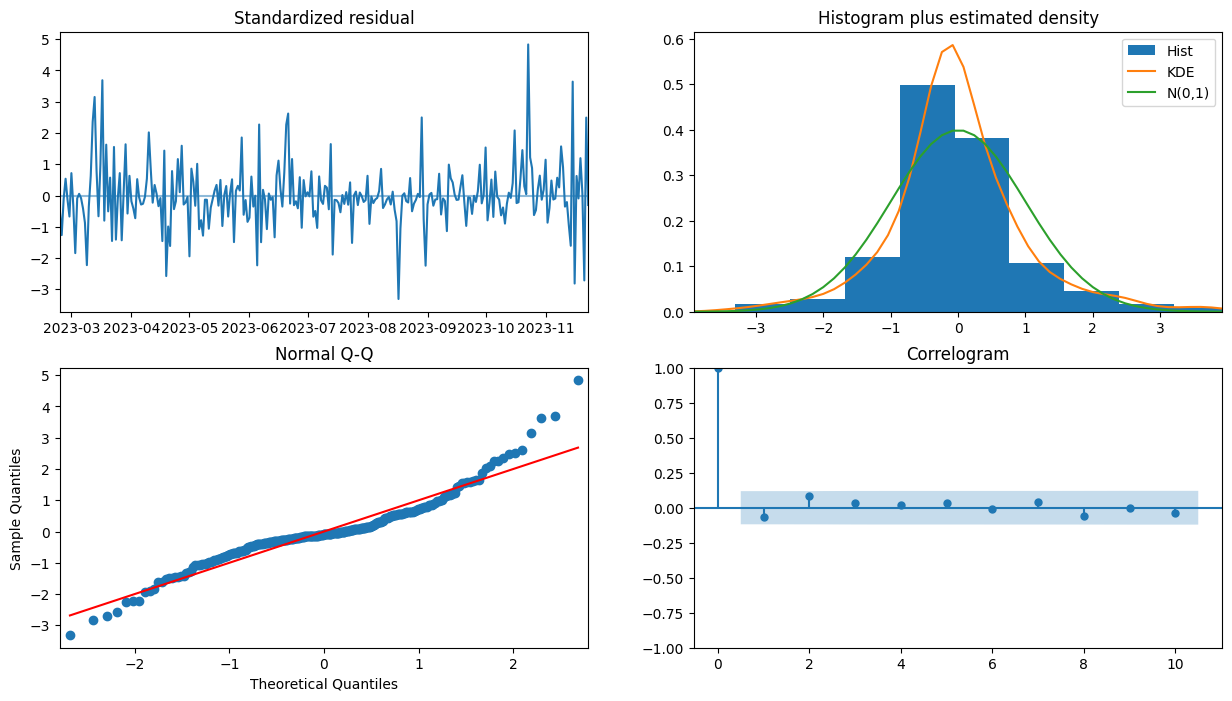

In [28]:
stepwise_model_fit.plot_diagnostics(figsize=(15,8))
plt.show()

* 잔차가 백색 잡음을 따르는지 보여주는 그래프는 (1,1)과 (2,2)에 위치한 그래프입니다.
* (1,1)은 잔차를 그냥 시계열로 그린것이며, (2,2)는 잔차에 따른 ACF입니다, 이를통해 시계열이 평균 0을 중심으로 무작위하게 움직이는 것을 확인 할 수 있고, ACF도 허용범위안에 위치함을 확인 할 수 있습니다.
* 잔차가 정규성을 만족하는지 보여주는 그래프는 (1,2)와 (2,1)에 위치한 그래프입니다.
* (1,2)는 잔차의 히스토그램을 그려 정규 분포 N(0,1)과 밀도를 추정한 그래프를 같이 겹쳐서 보여줍니다.
* (2,1)그래프는 Q-Q 플랏으로 정규성을 만족한다면 빨간 일직선 위에 점들이 분포해야 합니다. 그러나, 양 끝 쪽에서 빨간 선을 약간 벗어나는 듯한 모습을 확인할 수 있습니다.

              Prediction
Date                    
2023-11-24  37337.434150
2023-11-25  37385.247206
2023-11-26  37433.060262
2023-11-27  37480.873318
2023-11-28  37528.686374
...                  ...
2024-01-28  40445.282790
2024-01-29  40493.095846
2024-01-30  40540.908902
2024-01-31  40588.721958
2024-02-01  40636.535014

[70 rows x 1 columns]


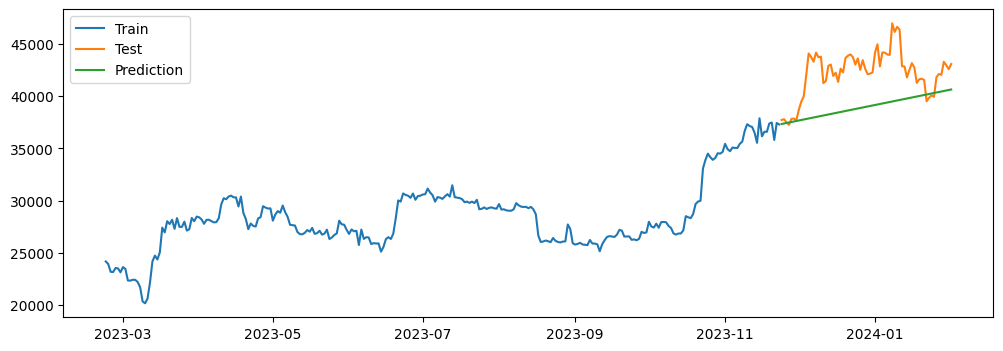

In [29]:
# 테스트 데이터 개수만큼 예측
y_predict = stepwise_model_fit.predict(n_periods = len(test_df['Close'])) 
y_predict = pd.DataFrame(y_predict, index = test_df['Close'].index, columns=['Prediction'])
print(y_predict)

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_df['Close'], label='Train')# 훈련 데이터
plt.plot(test_df['Close'], label='Test')# 테스트 데이터
plt.plot(y_predict, label='Prediction')# 예측 데이터
plt.legend()
plt.show()

## 피쳐 엔지니어링(train_df['Close'] 로그변환)

In [30]:
test_df['Close-log'] = np.log(test_df['Close'])

In [31]:
stepwise_model = pm.auto_arima(train_df['Close-log'],
                            start_p=0,
                            d=1,
                            start_q=0,
                            max_p=3,
                            max_q=3,
                            seasonal=False,
                            suppress_warning=True,
                            stepwise=False)
print(stepwise_model)
stepwise_model_fit = stepwise_model.fit(train_df['Close-log'])


 ARIMA(0,1,0)(0,0,0)[0] intercept


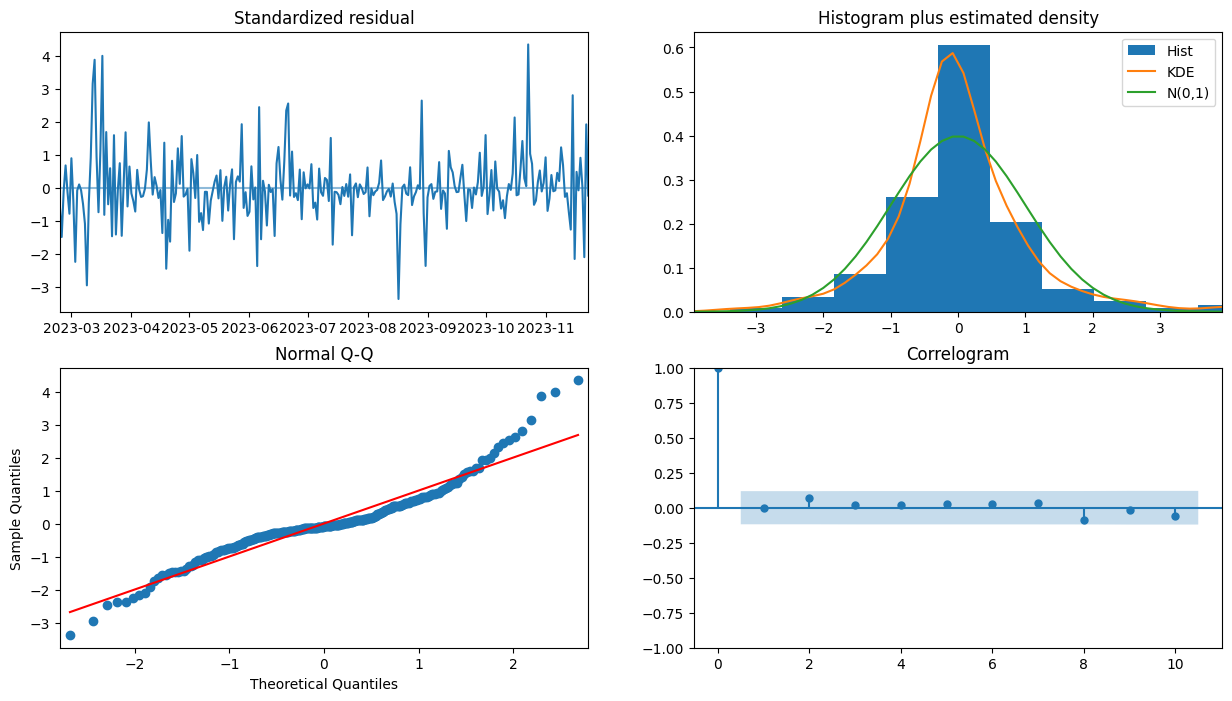

In [32]:
stepwise_model_fit.plot_diagnostics(figsize=(15,8))
plt.show()

            Prediction
Date                  
2023-11-24   10.528050
2023-11-25   10.529630
2023-11-26   10.531209
2023-11-27   10.532789
2023-11-28   10.534369
...                ...
2024-01-28   10.630727
2024-01-29   10.632307
2024-01-30   10.633886
2024-01-31   10.635466
2024-02-01   10.637046

[70 rows x 1 columns]


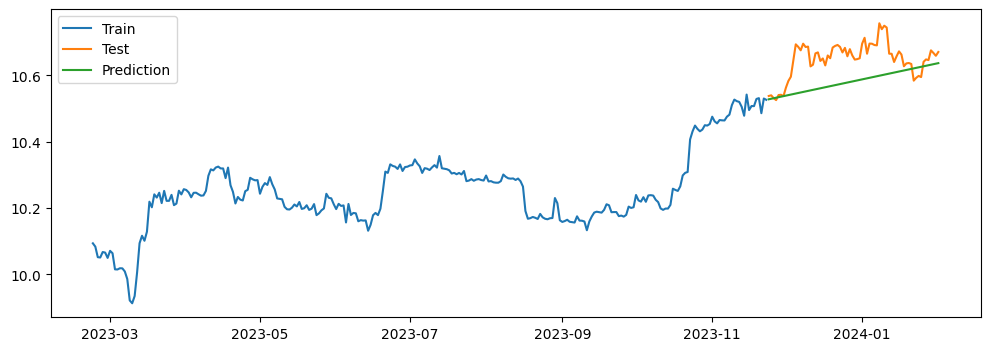

In [41]:
# 테스트 데이터 개수만큼 예측
y_predict = stepwise_model_fit.predict(n_periods = len(test_df['Close-log'])) 
y_predict = pd.DataFrame(y_predict, index = test_df['Close-log'].index, columns=['Prediction'])
print(y_predict)

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_df['Close-log'], label='Train')# 훈련 데이터
plt.plot(test_df['Close-log'], label='Test')# 테스트 데이터
plt.plot(y_predict, label='Prediction')# 예측 데이터

plt.legend()
plt.show()

            Prediction
Date                  
2023-11-24   10.528050
2023-11-25   10.529630
2023-11-26   10.531209
2023-11-27   10.532789
2023-11-28   10.534369
...                ...
2024-01-28   10.630727
2024-01-29   10.632307
2024-01-30   10.633886
2024-01-31   10.635466
2024-02-01   10.637046

[70 rows x 1 columns]

                Lower      Upper
Date                            
2023-11-24  10.484422  10.571678
2023-11-25  10.467930  10.591329
2023-11-26  10.455643  10.606775
2023-11-27  10.445533  10.620045
2023-11-28  10.436814  10.631924
...               ...        ...
2024-01-28  10.276292  10.985162
2024-01-29  10.275197  10.989417
2024-01-30  10.274121  10.993651
2024-01-31  10.273065  10.997867
2024-02-01  10.272028  11.002063

[70 rows x 2 columns]


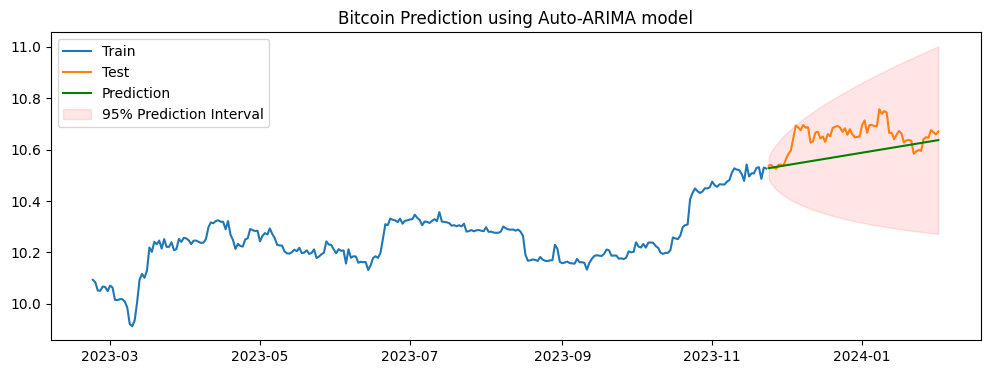

In [71]:
# Assuming stepwise_model_fit is your fitted ARIMA model
stepwise_model = pm.auto_arima(train_df['Close-log'],
                                start_p=0,
                                d=1,
                                start_q=0,
                                max_p=3,
                                max_q=3,
                                seasonal=False,
                                suppress_warnings=True,
                                stepwise=False)

# Fit the ARIMA model
stepwise_model_fit = stepwise_model.fit(train_df['Close-log'])

# Get the forecast and confidence intervals
forecast, conf_int = stepwise_model_fit.predict(n_periods=len(test_df['Close-log']), return_conf_int=True)

# Convert forecast and confidence intervals to DataFrame
y_predict = pd.DataFrame(forecast, index=test_df['Close-log'].index, columns=['Prediction'])
conf_int_df = pd.DataFrame(conf_int, index=test_df['Close-log'].index, columns=['Lower', 'Upper'])
print(y_predict)
print()
print(conf_int_df)

# Plot the original data, predictions, and 95% prediction interval
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_df['Close-log'], label='Train')
plt.plot(test_df['Close-log'], label='Test')
plt.plot(y_predict, label='Prediction', color='Green')
plt.fill_between(test_df['Close-log'].index, conf_int_df['Lower'], conf_int_df['Upper'], color='red', alpha=0.1, label='95% Prediction Interval')

plt.title("Bitcoin Prediction using Auto-ARIMA model")
plt.legend()
plt.show()

## 모델 평가 지표 만들기

In [2]:
# from datetime import datetime, timedelta
# future_li = []

# for i in range(1, 31):
#     dt = datetime.now()
#     td = timedelta(days = i)
#     future_dates = dt + td
#     future_li.append(future_dates.strftime('%Y-%m-%d'))
#     i=i+1

# future_df = pd.DataFrame(future_li)
# future_df = future_df.set_index(0)
# future_df = future_df.rename(index={0:'Date'})
# future_df

In [1]:
# # 테스트 데이터 개수만큼 예측
# y_predict = stepwise_model_fit.predict(n_periods = len(future_df.index))
# y_predict = pd.DataFrame(y_predict, index = future_df.index, columns=['Prediction'])
# print(y_predict)

# # 그래프
# fig, axes = plt.subplots(1, 1, figsize=(12, 4))
# plt.plot(train_df['Close-log'], label='Train')# 훈련 데이터
# plt.plot(test_df['Close-log'], label='Test')# 테스트 데이터
# plt.plot(y_predict, label='Prediction')# 예측 데이터

# plt.legend()
# plt.show()